In [21]:
from langchain_community.retrievers import WikipediaRetriever, ArxivRetriever
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_classic.tools import tool

wiki = WikipediaRetriever(top_k_results=3)

# @tool
def search_wiki(query: str):
    """Useful for general knowledge and history. Input: a search string."""
    result = wiki.invoke(input=query)

    content = [str(res.metadata.get('summary'))[:1000] for res in result]
    url = [res.metadata.get('source') for res in result]
    
    return content, url
    

In [22]:
search_wiki('hitler')

(['Adolf Hitler (20 April 1889 – 30 April 1945) was an Austrian-born  German politician who was the dictator of Germany during the Nazi era, which lasted from 1933 until his suicide in 1945. He rose to power as the leader of the Nazi Party, becoming the chancellor of Germany in 1933 and then taking the title of Führer und Reichskanzler in 1934. Hitler\'s ideology was rooted in white nationalist principles promoting the "Aryan" (Germanic) race as biologically superior to other ethnic groups. He persued conquering Europe to ensure the dominance of this "master race" over supposedly inferior groups. His invasion of Poland on 1 September 1939 marked the outbreak of the Second World War. Throughout the ensuing conflict, Hitler was closely involved in the direction of German military operations as well as the perpetration of the Holocaust, the genocide of about six million Jews and millions of other victims.\nHitler was born in Braunau am Inn in Austria-Hungary and moved to Germany in 1913. 

In [23]:
arxiv = ArxivRetriever(top_k_results=3)
# @tool
def arxiv_search(query: str):
    """Searches and parses research papers on Arxiv"""
    result = arxiv.invoke(input=query)
    content = [res.page_content[:1000] for res in result]
    url = [res.metadata['Entry ID'] for res in result]
    
    return content, url


In [24]:
arxiv_search('Attention')

(['While originally designed for natural language processing tasks, the self-attention mechanism has recently taken various computer vision areas by storm. However, the 2D nature of images brings three challenges for applying self-attention in computer vision. (1) Treating images as 1D sequences neglects their 2D structures. (2) The quadratic complexity is too expensive for high-resolution images. (3) It only captures spatial adaptability but ignores channel adaptability. In this paper, we propose a novel linear attention named large kernel attention (LKA) to enable self-adaptive and long-range correlations in self-attention while avoiding its shortcomings. Furthermore, we present a neural network based on LKA, namely Visual Attention Network (VAN). While extremely simple, VAN surpasses similar size vision transformers(ViTs) and convolutional neural networks(CNNs) in various tasks, including image classification, object detection, semantic segmentation, panoptic segmentation, pose esti

In [29]:
import re

pattern = r"snippet: (.*?), title: (.*?), link: (.*?)(?=, snippet: |$)"
ddgs = DuckDuckGoSearchResults()

# @tool
def search_ddgs(query: str):
    """Searches DuckDuckGo to search for a specific topic with sources"""
    text = ddgs.invoke(input=query)
    matches = re.findall(pattern, text)
    snippet = [m[0][:1000] for m in matches]
    url = [m[2] for m in matches]
    
    return snippet, url

In [30]:
search_ddgs('obama')

(['Barack Hussein Obama II (/ bəˈrɑːk huːˈseɪn oʊˈbɑːmə / (listen); born August 4, 1961) [1] is an American politician and attorney. He was the 44th president of the United States from 2009 to 2017.',
  'The allegations of Barack Obama spying on Donald Trump encompass claims that the Obama administration engaged in or oversaw unauthorized...',
  'Barack Obama , the 44th President of the United States, broke barriers as the first African-American president and implemented significant healthcare reforms during his tenure.',
  'Former first lady Michelle Obama said in a new interview that the country is moving toward the direction of having a woman president — taking a softer approach after previously saying the ...'],
 ['https://simple.wikipedia.org/wiki/Barack_Obama',
  'https://grokipedia.com/page/Allegations_of_Barack_Obama_spying_on_Donald_Trump',
  'https://www.britannica.com/biography/Barack-Obama',
  'https://www.cnn.com/2026/01/21/politics/michelle-obama-says-us-moving-toward-hav

In [121]:
@tool
def search_wiki(query: str):
    """Useful for searching Wikipedia for general knowledge, history, and detailed background information. 
    Input should be a search query string."""
    result = wiki.invoke(input=query)
    # Reducing payload size slightly to avoid token limit errors in 2026 models
    return [{content.metadata.get('title'): content.page_content[:2000]} for content in result]

@tool
def arxiv_search(query: str):
    """Useful for searching Arxiv to find academic research papers, technical reports, and deep scientific explanations. 
    Input should be a scientific or technical search query."""
    result = arxiv.invoke(input=query)
    return [{content.metadata.get('Title'): content.page_content[:2000]} for content in result]

@tool
def search_ddgs(query: str):
    """Useful for searching the live web via DuckDuckGo to get current events, news, or specific website links. 
    Input should be a concise search query."""
    text = ddgs.invoke(input=query)
    matches = re.findall(pattern, text)
    parsed_data = [
        {"snippet": m[0], "title": m[1], "link": m[2]} 
        for m in matches
    ]
    return parsed_data

In [122]:
from langchain_groq import ChatGroq
from langchain_classic.agents import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

llm = ChatGroq(model='llama-3.3-70B-Versatile')

PROMPT = ChatPromptTemplate.from_messages([('system',"""You are an intelligent assistant that can reason step by step and use tools to answer questions.

You have access to the following tools:

{tools}

Tool usage rules:
- Use tools only when necessary.
- Use EXACT tool names as provided.
- Provide arguments EXACTLY as defined in the tool schema.
- Do NOT invent parameters.
- Omit optional parameters unless required.
- If you do not need a tool, answer directly.

Use the following format for every reasoning step:

Question:
{input}

Scratchpad:

{agent_scratchpad}

Thought:
You should think about what to do next.

Action:
The action to take, must be one of [{tool_names}].

{intermediate_steps}

Action Input:
A JSON object containing ONLY the arguments required by the tool.

Observation:
The result of the tool call.

(Repeat Thought / Action / Action Input / Observation as needed)

Thought:
I now know the final answer.

Final Answer:
A clear, concise answer to the user.
"""),('human','{input}')])



agent = create_react_agent(llm=llm,
                           tools=[search_wiki,search_ddgs,arxiv_search],
                           prompt=PROMPT)


In [123]:
from langchain_classic.agents import AgentExecutor, AgentType
from langgraph.prebuilt import create_react_agent

In [124]:


# 1. Wrap your agent in an AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=[search_wiki,search_ddgs,arxiv_search], verbose=True,
                               max_iterations=3)
# 2. Call the executor instead
try:
    agent_executor.invoke({'input':'What are neural networks'})
except Exception as e:
    # This will print the specific API error (e.g., "Invalid model", "Too many tokens")
    if hasattr(e, 'body'):
        print(f"API Error Detail: {e.body}")
    else:
        print(f"Error: {e}")



> Entering new AgentExecutor chain...
Scratchpad:



Thought: To answer this question, I need to find a reliable source that provides a comprehensive overview of neural networks. Wikipedia is a good starting point for general knowledge and background information.

Action: search_wiki

Action Input:
```
{
  "query": "neural network"
}
```


KeyboardInterrupt: 

In [125]:
from langchain_core.prompts import PromptTemplate

template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought: {agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)


# Re-create the agent with the fixed prompt
agent = create_react_agent(model=llm, tools=[search_wiki, search_ddgs, arxiv_search], prompt=PROMPT,
                           )

# Updated AgentExecutor
agent_executor = AgentExecutor(
    agent=agent, 
    tools=[search_wiki, search_ddgs, arxiv_search], 
    verbose=True,
    max_iterations=3,
    handle_parsing_errors=True  # CRITICAL: Prevents hanging on formatting errors
)

# Run
agent_executor.invoke({'input': 'What are neural networks'})


/tmp/ipykernel_33967/105647917.py:27: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(model=llm, tools=[search_wiki, search_ddgs, arxiv_search], prompt=PROMPT,




> Entering new AgentExecutor chain...


KeyError: "Input to ChatPromptTemplate is missing variables {'intermediate_steps', 'tool_names', 'agent_scratchpad', 'input', 'tools'}.  Expected: ['agent_scratchpad', 'input', 'intermediate_steps', 'tool_names', 'tools'] Received: ['messages', 'remaining_steps']\nNote: if you intended {intermediate_steps} to be part of the string and not a variable, please escape it with double curly braces like: '{{intermediate_steps}}'.\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/INVALID_PROMPT_INPUT "

In [126]:
from langchain.agents import create_agent
tools=[search_wiki,search_ddgs,arxiv_search]

agent = create_agent(model=llm,
                     tools=tools,
                    )

In [127]:
agent.invoke({'input':'Neural Networks'})

BadRequestError: Error code: 400 - {'error': {'message': "'messages' : minimum number of items is 1", 'type': 'invalid_request_error'}}

In [ ]:
try:
    agent.invoke({'input':'Neural Networks'})
except Exception as e:
    print(f"Error Status Code: {e.status_code}")
    print(f"Error Message: {e.message}")


Error Status Code: 400
Error Message: Error code: 400 - {'error': {'message': "'messages' : minimum number of items is 1", 'type': 'invalid_request_error'}}


In [ ]:
llm.invoke('Hello')

AIMessage(content="Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_time': 0.054188351, 'completion_tokens_details': None, 'prompt_time': 0.001944384, 'prompt_tokens_details': None, 'queue_time': 0.058583336, 'total_time': 0.056132735}, 'model_name': 'llama-3.3-70B-Versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdc0e-3d51-73e0-9554-21ec71985ca9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61})

In [128]:
from langchain_classic.agents import create_react_agent, AgentExecutor
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq

# 1. Initialize LLM
llm = ChatGroq(model='llama-3.3-70b-versatile', temperature=0)

# 2. Define the EXACT ReAct Template
# Note: You MUST include {tools}, {tool_names}, {input}, and {agent_scratchpad}
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought: {agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

# 3. Use the CLASSIC create_react_agent
# Important: Ensure your 'tools' list contains the @tool decorated functions
tools_list = [search_wiki, search_ddgs, arxiv_search]

agent = create_react_agent(llm, tools_list, prompt)

# 4. Initialize the Executor
agent_executor = AgentExecutor(
    agent=agent, 
    tools=tools_list, 
    verbose=True, 
    handle_parsing_errors=True,
    max_iterations=3
)

# 5. Invoke
agent_executor.invoke({"input": "What are neural networks"})




> Entering new AgentExecutor chain...
Thought: To answer this question, I need to find a reliable source that provides a comprehensive overview of neural networks. Since neural networks are a fundamental concept in artificial intelligence and computer science, I should start by searching for a general knowledge source.

Action: search_wiki
Action Input: neural networks

KeyboardInterrupt: 

In [10]:
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

tav = TavilySearchResults(max_results=3)
def search_tavily(query: str):
    """Can generaly search the web for anything. Use for deep search or intensive tasks"""
    results = tav.invoke(input=query)
    urls = [res['url'] for res in results]
    content = [res['content'][:500] for res in results]
    return content, urls

In [11]:
results = search_tavily(query='Hitler')

results[0]

['Adolf Hitler (born April 20, 1889, Braunau am Inn, Austria—died April 30, 1945, Berlin, Germany) was the leader of the Nazi Party (from 1920/21) and chancellor (Kanzler) and Führer of Germany (1933–45). His worldview revolved around two concepts: territorial expansion and racial supremacy. Those themes informed his decision to invade Poland, which marked the start of World War II, as well as the systematic killing of six million Jews and millions of others during the Holocaust.\n\nHitler’s father,',
 "Adolf Hitler was born on 20 April 1889 in Braunau am Inn, a town in Austria-Hungary (present-day Austria), close to the border with Germany. He was the fourth of six children born to Alois Hitler and his third wife, Klara Pölzl. Three of Hitler's siblings—Gustav, Ida, and Otto—died in infancy. Also living in the household were Alois's children from his second marriage: Alois Jr. (born 1882) and Angela (born 1883). In 1892, the family moved to Passau, Germany, following Alois's promotion

In [3]:
from langchain_classic.agents import create_react_agent, AgentExecutor
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.retrievers import WikipediaRetriever, ArxivRetriever
from langchain_community.tools import DuckDuckGoSearchResults

# 1. Tool Definitions with optimized docstrings for 2026 LLMs
wiki = WikipediaRetriever(top_k_results=2)
arxiv = ArxivRetriever(top_k_results=2)
ddgs = DuckDuckGoSearchResults()

@tool
def search_wiki(query: str):
    """Useful for general knowledge and history. Input: a search string."""
    result = wiki.invoke(input=query)
    return [{c.metadata.get('title', 'Wiki'): c.page_content[:1500]} for c in result]

@tool
def arxiv_search(query: str):
    """Useful for scientific and technical research papers. Input: a technical string."""
    result = arxiv.invoke(input=query)
    return [{c.metadata.get('Title', 'Arxiv'): c.page_content[:1500]} for c in result]

@tool
def search_ddgs(query: str):
    """Useful for current news and live web links. Input: a concise search query."""
    text = ddgs.invoke(input=query)
    # Generic parse for search results
    return text[:2000]

tools_list = [search_wiki, search_ddgs, arxiv_search, search_tavily]

# 2. ReAct Prompt Template (Mandatory variables: tools, tool_names, input, agent_scratchpad)
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format strictly:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought: {agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

# 3. Initialize LLM (Temperature 0 is critical for formatting stability)
llm = ChatGroq(
    model='llama-3.3-70b-versatile', 
    temperature=0,
    groq_api_key="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" # Replace with your key
)

# 4. Create the Agent using the CLASSIC factory
agent = create_react_agent(llm, tools_list, prompt)

# 5. Initialize AgentExecutor with error handling
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools_list,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=3
)

# 6. Execution
result = agent_executor.invoke({"input": "What are neural networks?"})
print(result["output"])


/home/programmerrez/miniconda3/envs/ml/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


AttributeError: 'function' object has no attribute 'name'

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal, List, Optional, Tuple
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from tools import search_tavily
import requests

# =========================
# STATE
# =========================

class ResearchState(BaseModel):
    topic: str
    mode: Literal["shallow", "deep"]

    plan: List[str] = Field(default_factory=list)
    queries: List[str] = Field(default_factory=list)

    raw_results: List[List[str]] = Field(default_factory=list)

    # (url, extracted_text)
    extracted_notes: List[Tuple[str, str]] = Field(default_factory=list)

    validated_notes: List[str] = Field(default_factory=list)
    validated_sources: List[str] = Field(default_factory=list)

    depth: int = 0
    max_depth: int = 1

    final_report: Optional[str] = None


# =========================
# STRUCTURED OUTPUTS
# =========================

class ResearchPlan(BaseModel):
    subtopics: List[str]
    depth_required: int
    requires_math: bool
    requires_sources: bool


# =========================
# MODELS
# =========================

model = ChatGroq(model="llama-3.1-8b-instant")
planner = model.with_structured_output(ResearchPlan)


# =========================
# NODES
# =========================

def plan_node(state: ResearchState) -> ResearchState:
    plan = planner.invoke(
        f"Topic: {state.topic}\nMode: {state.mode}"
    )
    state.plan = plan.subtopics
    state.max_depth = plan.depth_required
    return state


def search_node(state: ResearchState) -> ResearchState:
    if state.depth >= state.max_depth:
        return state

    state.depth += 1

    for subtopic in state.plan:
        text, urls = search_tavily.invoke(subtopic)
        state.queries.append(subtopic)
        state.raw_results.append(text)

        for url in urls:
            try:
                r = requests.get(url, timeout=5)
                if r.status_code == 200:
                    state.extracted_notes.append(
                        (url, r.text[:800])
                    )
            except requests.RequestException:
                continue

    return state


def validate_node(state: ResearchState) -> ResearchState:
    seen_notes = set()

    for url, note in state.extracted_notes:
        if not note:
            continue
        if note in seen_notes:
            continue

        seen_notes.add(note)
        state.validated_notes.append(note)
        state.validated_sources.append(url)

    return state


def synthesize_node(state: ResearchState) -> ResearchState:
    report = f"# {state.topic}\n\n"

    for note in state.validated_notes:
        report += f"- {note[:300]}\n\n"

    report += "\n## References\n"
    for src in state.validated_sources:
        report += f"- {src}\n"

    state.final_report = report
    return state


# =========================
# ROUTER
# =========================

def should_continue(state: ResearchState) -> bool:
    return state.depth < state.max_depth


# =========================
# GRAPH
# =========================

graph = StateGraph(ResearchState)

graph.add_node("plan", plan_node)
graph.add_node("search", search_node)
graph.add_node("validate", validate_node)
graph.add_node("synthesize", synthesize_node)

graph.set_entry_point("plan")

graph.add_edge("plan", "search")
graph.add_edge("search", "validate")

graph.add_conditional_edges(
    "validate",
    should_continue,
    {
        True: "search",
        False: "synthesize",
    },
)

graph.add_edge("synthesize", END)

research_agent = graph.compile()



/home/programmerrez/miniconda3/envs/ml/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
/home/programmerrez/miniconda3/envs/ml/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
/run/media/programmerrez/Field Testing/Side-Projects/Advanced Agent/tools/__init__.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead.

In [2]:

# =========================
# RUN
# =========================

if __name__ == "__main__":
    state = ResearchState(
        topic="Neural Networks",
        mode="deep"
    )

    for step in research_agent.stream(state):
        print(step)


{'plan': {'topic': 'Neural Networks', 'mode': 'deep', 'plan': ['Backpropagation', 'Activation Functions', 'Convolutional Neural Networks', 'Recurrent Neural Networks'], 'queries': [], 'raw_results': [], 'extracted_notes': [], 'validated_notes': [], 'validated_sources': [], 'depth': 0, 'max_depth': 2}}


ValidationError: 4 validation errors for ResearchState
raw_results.0
  Input should be a valid string [type=string_type, input_value=['In machine learning, ba...ropagation was one of '], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.1
  Input should be a valid string [type=string_type, input_value=['»\n Tutorial 3: Activa...ying by zero.\n\nRNN r'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.2
  Input should be a valid string [type=string_type, input_value=['CNNs are distinguished ...s. With a proper train'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.3
  Input should be a valid string [type=string_type, input_value=['Each word in the phrase...\u2062𝐱 𝑡+𝐖 '], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type

In [7]:
from langgraph.graph import StateGraph

graph = StateGraph(ResearchState)

graph.add_node("plan", plan_node)
graph.add_node("search", search_node)
graph.add_node("extract", extract_node)
graph.add_node("validate", validate_node)
graph.add_node("synthesize", synthesize_node)

graph.set_entry_point("plan")
graph.add_edge("plan", "search")
graph.add_edge("search", "extract")
graph.add_edge("extract", "validate")

graph.add_conditional_edges(
    "validate",
    should_continue,
    {
        True: "search",
        False: "synthesize"
    }
)

research_agent = graph.compile()


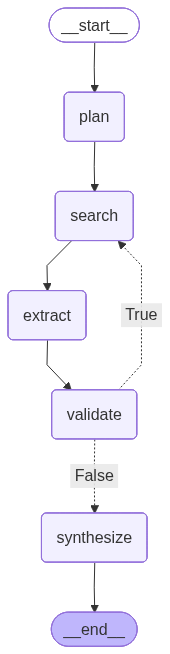

In [8]:
research_agent

In [3]:
state = ResearchState(topic="Neural Networks", mode="deep")

research_agent.invoke(state)

ValidationError: 10 validation errors for ResearchState
raw_results.0
  Input should be a valid string [type=string_type, input_value=['# Artificial Neural Net...etermine the strength '], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.1
  Input should be a valid string [type=string_type, input_value=['High Accuracy and Perfo...logous to the neural n'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.2
  Input should be a valid string [type=string_type, input_value=['CNNs are distinguished ...s. With a proper train'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.3
  Input should be a valid string [type=string_type, input_value=['Each word in the phrase...\u2062𝐱 𝑡+𝐖 '], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.4
  Input should be a valid string [type=string_type, input_value=['View PDF\n> Abstract:Th...e structure of a neura'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.5
  Input should be a valid string [type=string_type, input_value=['»\n Tutorial 3: Activa...ying by zero.\n\nRNN r'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.6
  Input should be a valid string [type=string_type, input_value=['In machine learning, ba...ropagation was one of '], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.7
  Input should be a valid string [type=string_type, input_value=["Close\n\nCaption:\n\nTh... Optimization for Spec'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.8
  Input should be a valid string [type=string_type, input_value=["Conclusion\n\nMastering...on test data.\n\nRegul'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.9
  Input should be a valid string [type=string_type, input_value=['In AI, transfer learnin...the source data, the m'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type

In [11]:
state = ResearchState(topic="Neural Networks", mode="deep")

for event in research_agent.stream(state):
    print(event)


{'plan': {'topic': 'Neural Networks', 'mode': 'deep', 'plan': ['Types of Neural Networks', 'Activation Functions', 'Backpropagation Algorithm'], 'queries': [], 'raw_results': [], 'extracted_notes': [], 'validated_notes': [], 'candidate_sources': [], 'validated_sources': [], 'depth': 0, 'max_depth': 3, 'halted': False}}


ValidationError: 3 validation errors for ResearchState
raw_results.0
  Input should be a valid string [type=string_type, input_value=['Home\n/\nCloud Terms\n/...tly, the fully connect'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.1
  Input should be a valid string [type=string_type, input_value=['»\n Tutorial 3: Activa...ying by zero.\n\nRNN r'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
raw_results.2
  Input should be a valid string [type=string_type, input_value=['In the backward pass, t...igure out how to write"], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type